# Data preproccsing

In [60]:
# libs load

import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [51]:
# load data 

path = "df = pd.read_csv(path)

In [52]:
# knowing our data


display(df.describe(include='all').T)
display(df.head(10))
print(df.columns.tolist())
display(df.info())

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Datetime,121273,121269,2015-11-01 02:00:00,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AEP_MW,121273.0,NaN,NaN,NaN,15499.513717,2591.399065,9581.0,13630.0,15310.0,17200.0,25695.0


,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
5,2004-12-31 06:00:00,13038.0
6,2004-12-31 07:00:00,13692.0
7,2004-12-31 08:00:00,14297.0
8,2004-12-31 09:00:00,14719.0
9,2004-12-31 10:00:00,14941.0


['Datetime', 'AEP_MW']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


None

## Data Cleaning

In [53]:
# Number of the NaN data 

df.isna().sum()

Datetime    0
AEP_MW      0
dtype: int64

In [54]:
# make sure the datatime data is datatime.type

df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

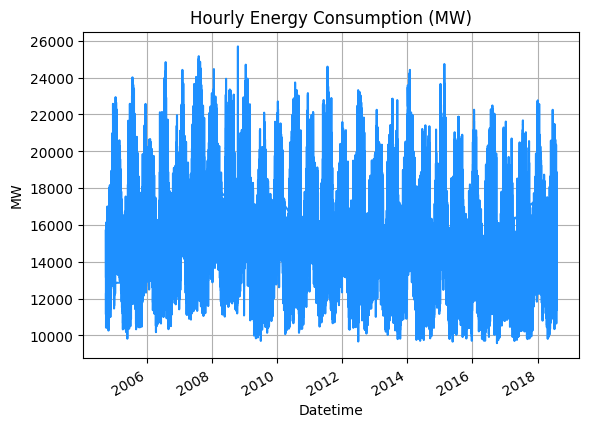

In [55]:
# visual data

plt.Figure(figsize=(15 , 5))
df['AEP_MW'].plot(title='Hourly Energy Consumption (MW)', color='dodgerblue')
plt.ylabel('MW')
plt.grid(True)
plt.show()

<Axes: title={'center': 'Monthly Average Consumption'}, xlabel='Datetime'>

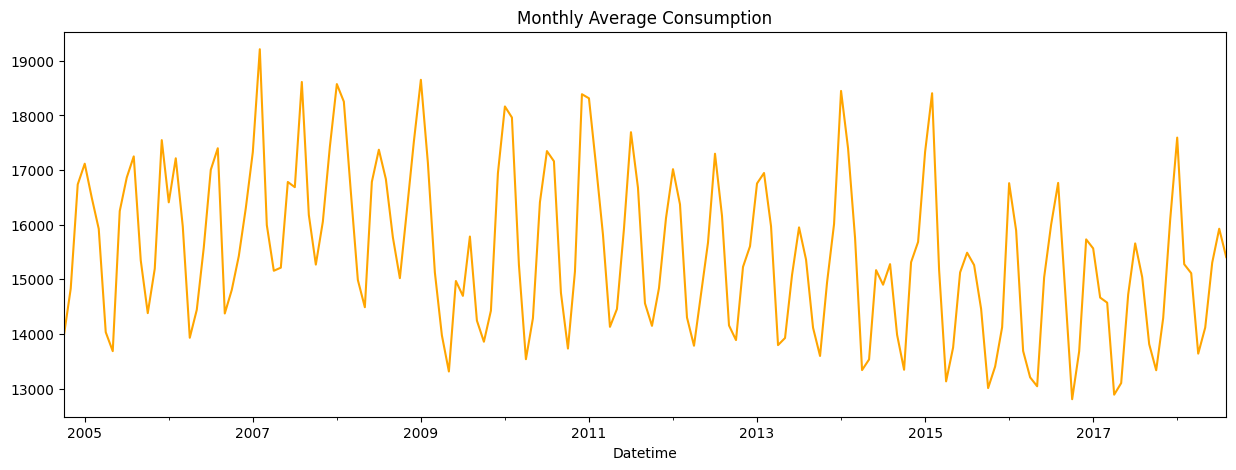

In [56]:
# mountly mean

df_monthly = df['AEP_MW'].resample('ME').mean()
plt.figure(figsize=(15 , 5))
df_monthly.plot(title="Monthly Average Consumption", color="orange")

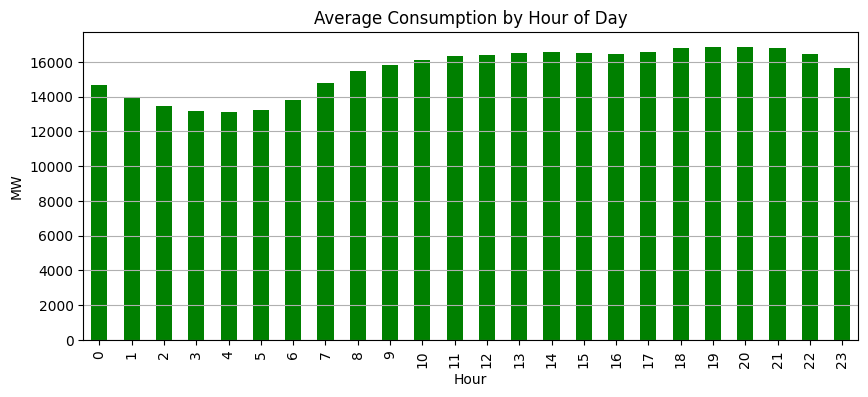

In [57]:
# hourly_pattern

hourly_pattern = df.groupby(df.index.hour)['AEP_MW'].mean()
plt.figure(figsize=(10, 4))
hourly_pattern.plot(kind='bar', color='green', title='Average Consumption by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('MW')
plt.grid(axis='y')
plt.show()

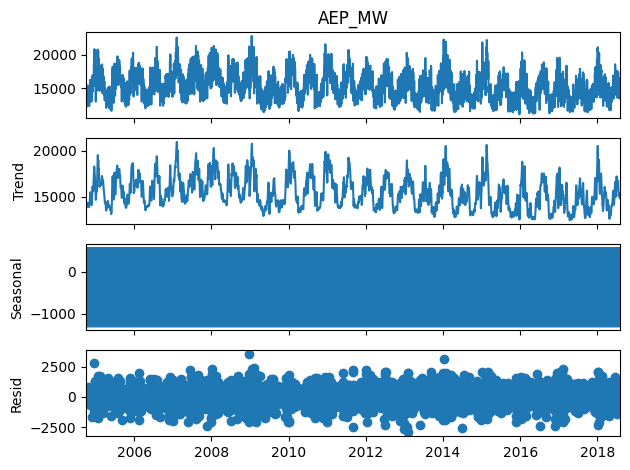

In [58]:
ts = df['AEP_MW'].resample('D').mean()

result = seasonal_decompose(ts, model='additive')

result.plot()
plt.tight_layout()
plt.show()

14:22:22 - cmdstanpy - INFO - Chain [1] start processing
14:22:25 - cmdstanpy - INFO - Chain [1] done processing


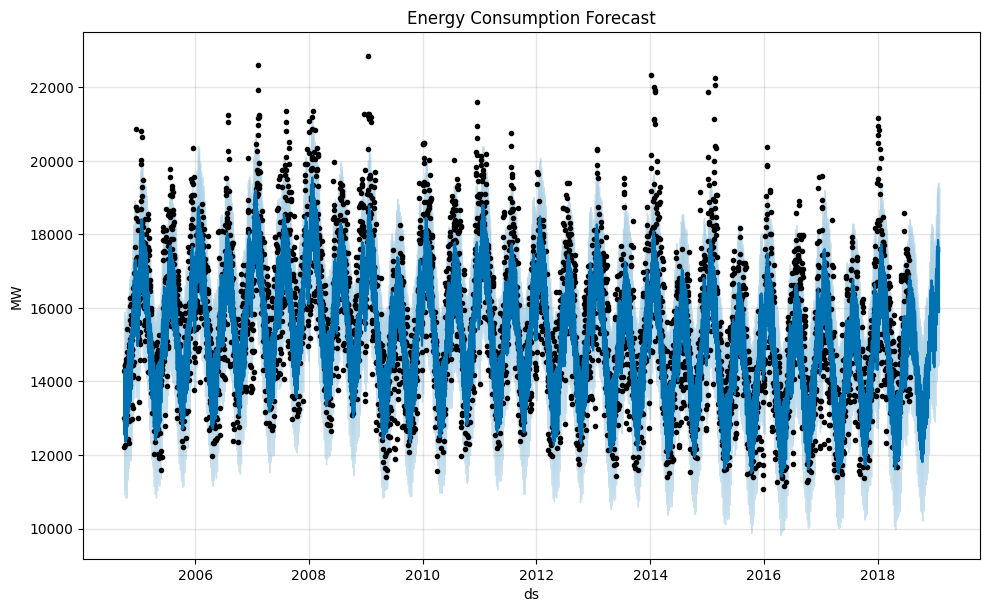

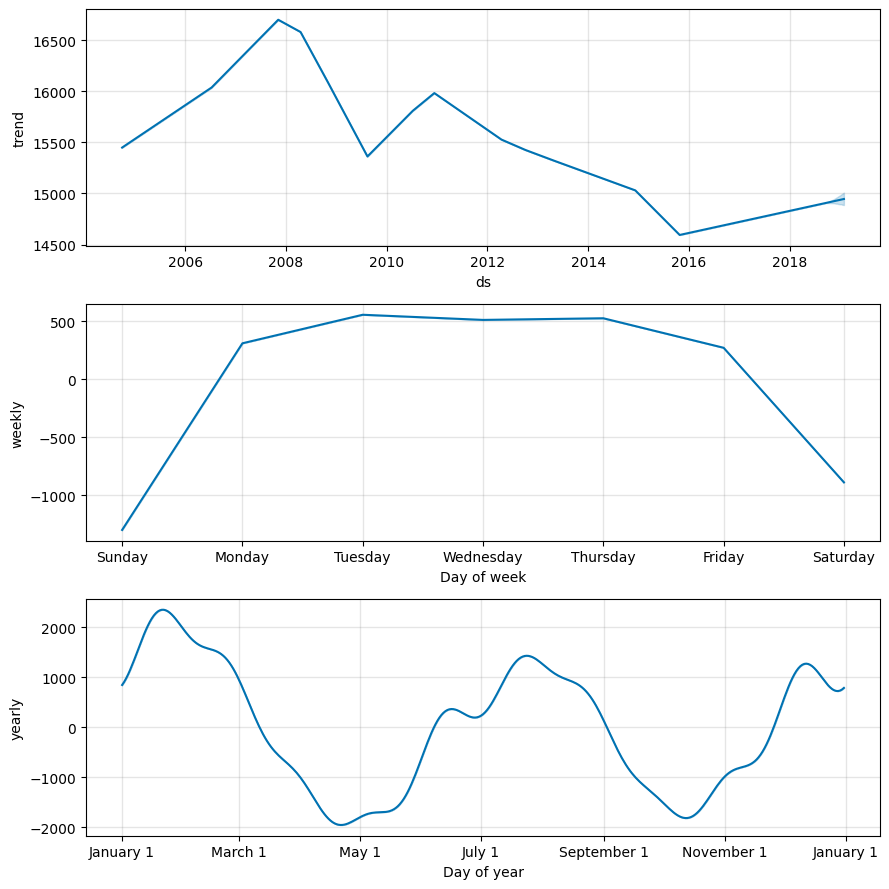

In [59]:
# change format 
df_prophet = df['AEP_MW'].resample("D").mean().reset_index()
df_prophet.columns = ['ds','y']

# train and make model 
model = Prophet()
model.fit(df_prophet)

# def predic range for 6 month
future = model.make_future_dataframe(periods=180)
forecast = model.predict(future)

# plot the result
model.plot(forecast)
plt.title("Energy Consumption Forecast")
plt.ylabel("MW")
plt.show()

model.plot_components(forecast)
plt.tight_layout()
plt.show()

In [63]:
# split test and trian 
split_point = int(len(df_prophet)* 0.8)
trian = df_prophet.iloc[:split_point]
test = df_prophet.iloc[split_point:]

# trian on the model
model = Prophet()
model.fit(trian)

# make the future until test data
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)

# extract predict of the test
forecast_test = forecast[['ds', 'yhat']].iloc[-len(test):]
y_true = test['y'].values
y_pred = forecast_test['yhat'].values

# clac the mistake
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

14:44:16 - cmdstanpy - INFO - Chain [1] start processing
14:44:17 - cmdstanpy - INFO - Chain [1] done processing


MAE: 1106.52
RMSE: 1435.35


its not good enough
lets try another model and ml model

In [ ]:
# make the future with future engineering

df_feat = df['AEP_MW'].resample('D').mean().to_frame()
df_feat['date'] = df_feat.index
df_feat['dayofweek'] = df_feat['date'].dt.dayofweek
df_feat['month'] = df_feat['date'].dt.month
df_feat['day'] = df_feat['date'].dt.day
df_feat['is_weekend'] = df_feat['dayofweek'] >= 5

In [65]:
# lag future 

df_feat['lag_1'] = df_feat['AEP_MW'].shift(1)
df_feat['lag_7'] = df_feat['AEP_MW'].shift(7)

In [66]:
df_feat['rolling_3'] = df_feat['AEP_MW'].rolling(3).mean()
df_feat['rolling_7'] = df_feat['AEP_MW'].rolling(7).mean()

In [ ]:
df_feat.dropna(inplace=True)

In [68]:
from sklearn.model_selection import train_test_split

X = df_feat.drop(['AEP_MW', 'date'], axis=1)
y = df_feat['AEP_MW']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [78]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [79]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 456.19
RMSE: 607.10


خطا نصف شد 